In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
dff = pd.read_excel('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx')

In [4]:
dff

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Indonesia,IDN,"PPP conversion factor, private consumption (LC...",PA.NUS.PRVT.PP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.047258e+02,8.447486e+02,8.816013e+02,9.391483e+02,9.933749e+02,1.057292e+03,1.109084e+03,1.151225e+03,1.796245e+03,2.117741e+03,2.124127e+03,2.303309e+03,2.537165e+03,2.648486e+03,2.735847e+03,2.922671e+03,3.202485e+03,3.313141e+03,3.516945e+03,3.684313e+03,3.810971e+03,3.892218e+03,3.833292e+03,4.163778e+03,4.412803e+03,4.720815e+03,4.877707e+03,5.089686e+03,5.127235e+03,5.188592e+03,NaN
1,Indonesia,IDN,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.898316e-01,1.887107e-01,1.901919e-01,2.153086e-01,2.194565e-01,2.269631e-01,2.325308e-01,2.071693e-01,1.043243e-01,1.496629e-01,1.644602e-01,1.509691e-01,1.734324e-01,1.949857e-01,1.977692e-01,2.019769e-01,2.369805e-01,2.572782e-01,2.810204e-01,2.818896e-01,3.670885e-01,4.005223e-01,3.803168e-01,3.599642e-01,3.397137e-01,3.251320e-01,3.394945e-01,3.509242e-01,3.342776e-01,3.352734e-01,NaN
2,Indonesia,IDN,"PPP conversion factor, GDP (LCU per internatio...",PA.NUS.PPP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.498235e+02,3.680463e+02,3.860744e+02,4.493707e+02,4.741906e+02,5.103491e+02,5.446568e+02,6.027342e+02,1.044661e+03,1.175624e+03,1.385047e+03,1.549072e+03,1.614862e+03,1.672419e+03,1.767829e+03,1.960133e+03,2.170579e+03,2.351780e+03,2.725606e+03,2.928815e+03,3.336994e+03,3.512754e+03,3.569893e+03,3.765672e+03,4.030775e+03,4.353327e+03,4.518104e+03,4.695659e+03,4.759089e+03,4.743337e+03,NaN
3,Indonesia,IDN,DEC alternative conversion factor (LCU per US$),PA.NUS.ATLS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.495830e+02,2.962920e+02,3.260000e+02,3.650000e+02,3.934200e+02,4.150000e+02,4.150000e+02,4.150000e+02,4.150000e+02,4.150000e+02,4.150000e+02,4.420500e+02,6.230600e+02,6.269900e+02,6.317600e+02,6.614200e+02,9.092600e+02,1.025940e+03,1.110580e+03,1.282560e+03,1.643850e+03,1.685700e+03,1.770060e+03,1.842810e+03,1.950320e+03,2.029920e+03,2.087100e+03,2.160750e+03,2.248600e+03,2.342300e+03,2.909380e+03,1.001360e+04,7.855150e+03,8.421775e+03,1.026085e+04,9.311191e+03,8.577133e+03,8.938850e+03,9.704742e+03,9.159317e+03,9.141000e+03,9.698962e+03,1.038994e+04,9.090433e+03,8.770433e+03,9.386629e+03,1.046124e+04,1.186521e+04,1.338941e+04,1.330833e+04,1.338083e+04,1.423694e+04,1.414767e+04,NaN
4,Indonesia,IDN,Terms of trade adjustment (constant LCU),NY.TTF.GNFS.KN,-7.364556e+13,-7.738148e+13,-6.235535e+13,-6.645311e+13,-7.634092e+13,-8.276038e+13,-9.274232e+13,-8.994220e+13,-9.295260e+13,-1.086969e+14,-1.187007e+14,-1.302320e+14,-1.571680e+14,-1.842127e+14,-1.316864e+14,-1.321367e+14,-1.491390e+14,-1.654078e+14,-1.650252e+14,-8.260263e+13,8.655831e+12,1.716088e+13,1.143605e+13,7.624546e+13,1.146783e+14,1.397930e+14,5.526039e+13,5.253666e+13,-2.769305e+13,-1.626339e+13,5.119249e+13,4.756417e+13,3.425378e+13,2.713362e+13,4.208338e+13,6.410578e+13,8.707165e+13,1.739524e+14,2.595925e+14,1.060772e+14,1.693321e+14,1.453234e+14,8.848081e+13,1.142335e+14,1.185877e+14,1.152788e+14,2.083647e+14,1.613457e+14,-4.435684e+12,3.563310e+13,0.000000e+00,3.806768e+13,-6.489509e+13,-1.424652e+14,-1.216710e+14,-1.072129e+14,-7.800819e+13,-7.938565e+13,-1.943508e+14,-2.902870e+14,NaN
5,Indonesia,IDN,Net secondary income (Net current transfers fr...,NY.TRF.NCTR.KN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "thing"})
        return name
    
    return df_formatted

In [6]:
def null_percent(data):
    
    percentage = (data.isnull().sum()/len(data))*100
    
    print('Percentage of NA/NAN in this set is: ', percentage)

In [7]:
def train_test_split(data, test_size):
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    return train, test

In [8]:
def plot_train_test(train_set, test_set):
    ax = plt.plot(train_set, label='Train set')
    ax = plt.plot(test_set, label='Test set', color = 'orange')
    
    return ax

In [9]:
"""
This function was refactored from:

https://towardsdatascience.com/predicting-electricity-consumption-with-xgbregressor-a11b71104754

https://towardsdatascience.com/xgboost-for-time-series-forecasting-dont-use-it-blindly-9ac24dc5dfa9

"""

def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range (len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i+previous, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
def walk_forward_validation(data, test_size):
    predictions = list()
    
    train, test = train_test_split(data, len(data) - int(len(data) * 0.8))
    
    history = [x for x in train]

In [11]:
def performance_metrics(y_test, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mean = np.mean(y_test)
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("R2 Score: ", r2)
    print("Mean of actual: ", mean)

In [12]:
def plot_ACF(data, lag):
    acfData = data.dropna()
    plot_acf(acfData, lags=lag)

In [13]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'NY.GDP.PCAP.KD.ZG')


In [14]:
null_percent(data)

Percentage of NA/NAN in this set is:  thing    3.278689
dtype: float64


<AxesSubplot:>

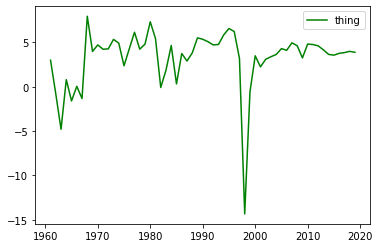

In [15]:
data.plot(color='green')

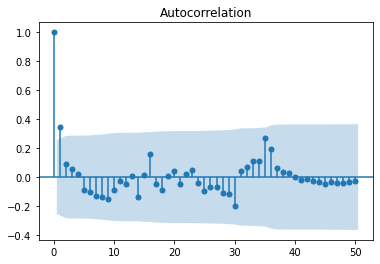

In [16]:
plot_ACF(data, 50)

In [17]:
#15 since the train is 75% of the data, and test is 25% of the data.
train, test = train_test_split(data, len(data) - int(len(data) * 0.8))

In [18]:
train, test = train.dropna(), test.dropna()

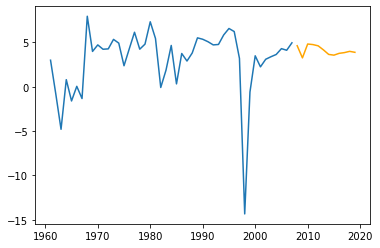

In [19]:
plot_train_test(train, test)

In [30]:
#Split of the dataset here
lookback = 1

X_train, Y_train = create_dataset(train.to_numpy(), lookback)
X_test, Y_test = create_dataset(test.to_numpy(), lookback)

In [21]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=3, learning_rate=0.1)
model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [22]:
testpred = model.predict(X_test)

RMSE:  3.453571080139637
MAPE:  46.599495863371246
MAE:  2.048247705002416
R2 Score:  -45.31271909667038
Mean of actual:  4.034605310459723


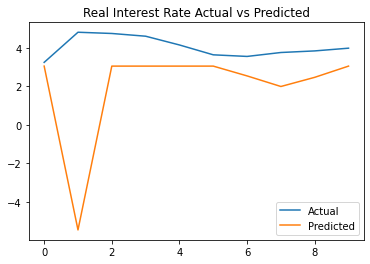

In [23]:
df_compare = pd.DataFrame({'Actual' : Y_test, 'Predicted' : testpred})
df_compare.plot(title='Real Interest Rate Actual vs Predicted')
performance_metrics(Y_test, testpred)

In [24]:
df_compare

,Actual,Predicted
0,3.247327,3.052655
1,4.812282,-5.458979
2,4.748221,3.052655
3,4.606284,3.052655
4,4.151271,3.052655
5,3.639143,3.052655
6,3.555440,2.543457
7,3.759694,1.993575
8,3.842334,2.469596
9,3.984057,3.052655


In [25]:
"""
Starting here is the hyperparameter optimisation for univariate forecasting

This piece of code was reused from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Fitted for my model
"""

def tune_n_estimator(X, y):
    hyperparam = {'max_depth': [3,6,10],
                 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                 'n_estimators': [5,10,50,100,1000]}
    
    model = XGBRegressor()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1)
    
    gscv.fit(X, y)
    
    print("Best hyperparam: ", gscv.best_params_)

In [26]:
"""
Using X_train and Y_train due to how the target variable works for
time series forecast with XGBoost
"""
#tune_n_estimator(X_train, Y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best hyperparam:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 10}


In [28]:
"""
Attempting out of sample forecast
"""

'\nAttempting out of sample forecast\n'